In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np

c:\Users\victory tech\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_csv('MSFT.csv')
df

,Date,Open,High,Low,Close,Volume
0,1986-03-13 00:00:00-05:00,0.054485,0.062498,0.054485,0.059827,1031788800
1,1986-03-14 00:00:00-05:00,0.059827,0.063032,0.059827,0.061963,308160000
2,1986-03-17 00:00:00-05:00,0.061963,0.063566,0.061963,0.063032,133171200
3,1986-03-18 00:00:00-05:00,0.063032,0.063566,0.060895,0.061429,67766400
4,1986-03-19 00:00:00-05:00,0.061429,0.061963,0.059827,0.060361,47894400
...,...,...,...,...,...,...
9753,2024-11-22 00:00:00-05:00,411.369995,417.399994,411.059998,417.000000,24814600
9754,2024-11-25 00:00:00-05:00,418.380005,421.079987,414.850006,418.790008,27691100
9755,2024-11-26 00:00:00-05:00,419.589996,429.040008,418.850006,427.989990,23458900
9756,2024-11-27 00:00:00-05:00,425.109985,427.230011,422.019989,422.989990,18332400


In [3]:
df = df[['Date', 'Close']]
df

,Date,Close
0,1986-03-13 00:00:00-05:00,0.059827
1,1986-03-14 00:00:00-05:00,0.061963
2,1986-03-17 00:00:00-05:00,0.063032
3,1986-03-18 00:00:00-05:00,0.061429
4,1986-03-19 00:00:00-05:00,0.060361
...,...,...
9753,2024-11-22 00:00:00-05:00,417.000000
9754,2024-11-25 00:00:00-05:00,418.790008
9755,2024-11-26 00:00:00-05:00,427.989990
9756,2024-11-27 00:00:00-05:00,422.989990


# Preprocessing Data

Avoiding errors by turning the data type of the date to datetime instead of object and also for an easier plotting using matplotlib

In [4]:
def string_to_date(date_string):
    date_part = date_string.split(' ')[0]   
    split = date_part.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)


In [5]:
df['Date'] = df['Date'].apply(string_to_date)
df['Date']

C:\Users\victory tech\AppData\Local\Temp\ipykernel_22896\2012105700.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = df['Date'].apply(string_to_date)


0      1986-03-13
1      1986-03-14
2      1986-03-17
3      1986-03-18
4      1986-03-19
          ...    
9753   2024-11-22
9754   2024-11-25
9755   2024-11-26
9756   2024-11-27
9757   2024-11-29
Name: Date, Length: 9758, dtype: datetime64[ns]

turning the date into the index in order to plot that table on a graph

In [6]:
df.index = df.pop('Date')
df

,Close
Date,
1986-03-13,0.059827
1986-03-14,0.061963
1986-03-17,0.063032
1986-03-18,0.061429
1986-03-19,0.060361
...,...
2024-11-22,417.000000
2024-11-25,418.790008
2024-11-26,427.989990


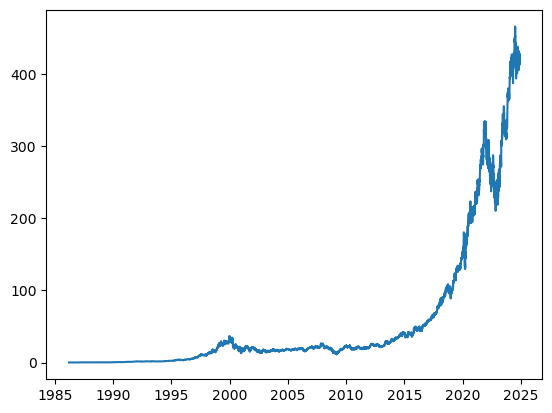

In [7]:
plt.plot(df.index, df['Close'])

Since we're using the LSTM model we'll need to convert this to a supervised learning problem

This will help the model with predicting the next few days or years but taking the 3 previous outputs of the previous days or years and outputting the prediction

In [13]:
def df_to_window(df, first_date, last_date, n=3):
    first_date = string_to_date(first_date)
    last_date = string_to_date(last_date)
    target_date = first_date

    dates = []
    X, Y = [], []
    last_time = False

    while True:
        df_subset = df.loc[:target_date].tail(n+1)
        if len(df_subset) < n + 1:
            print(f'Error, window size {n} is too large for {target_date}')
        
        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]
        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = df.loc[target_date:target_date + datetime.timedelta(days=7)]
        next_datetimeSTR = str(next_week.head(2).tail(1).index.values[0])
        next_dateSTR = next_datetimeSTR.split('T')[0]
        year_month_day = next_dateSTR.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(year=int(year), month=int(month), day=int(day))
        if last_time:
            break
        target_date = next_date

        if target_date == last_date:
            last_time = True
        
    retDF = pd.DataFrame()
    retDF['target date'] = dates
    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        retDF[f'Target - {n-i}'] = X[:, i]
    
    retDF['Target'] = Y
    return retDF

windowDF = df_to_window(df, '1986-03-18', '2024-11-29', n=3)
windowDF

,target date,Target - 3,Target - 2,Target - 1,Target
0,1986-03-18,0.059827,0.061963,0.063032,0.061429
1,1986-03-19,0.061963,0.063032,0.061429,0.060361
2,1986-03-20,0.063032,0.061429,0.060361,0.058758
3,1986-03-21,0.061429,0.060361,0.058758,0.057156
4,1986-03-24,0.060361,0.058758,0.057156,0.055554
...,...,...,...,...,...
9750,2024-11-22,416.955414,414.659973,412.869995,417.000000
9751,2024-11-25,414.659973,412.869995,417.000000,418.790008
9752,2024-11-26,412.869995,417.000000,418.790008,427.989990
9753,2024-11-27,417.000000,418.790008,427.989990,422.989990


converting the table into numpy arrays so we can give it directly to a tensorflow model

In [ ]:
def windowedDF_to_dateXY(windowDF):
    df_as_np = windowDF.to_numpy()
    dates  = df_as_np[:, 0]
    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1] , 1))
    Y = df_as_np[:, -1]
    return dates, X.astype(np.float32), Y.astype(np.float32)